# TO DO

1. Plot histogram of all SSIM and MS-SSIM values
2. Filter out only the SSIM values that are greater than roughly 0.8 (look at the data again before making this decision)
3. Plot scatterplots and boxplots again, but only for the data in the new range.

# Takeaways
- Both comparisons (using confidence vectors and IoU values) resemble a `polynom of degree 3` (however, sinc the model is well-trained, data with lower IoU values / low probability of being correct `is missing` -> a need to find data in this range to verify that p = 3??)
- Using confidence vector is more consistent than IoU values.
- SSIM and VLAD are not correlated.
- VLAD and Fisher are strongly correlated.
- In the confidence vector comparison: almost `90% of data points` are concentrated in the last bin! (0.9-1.0)

## 0. First, check the effect of blurring on SSIM and MS-SSIM

In [86]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.config import ROOT
from src.utils import *
from models.Segmentation import DeepLabV3Model, DeepLabV3PlusModel, UNetModel, PyramidAttentionNetworkModel

In [87]:
plots_path_ssim = f'{ROOT}/res/plots/ssim'
plots_path_ms_ssim = f'{ROOT}/res/plots/msssim'
model = 'DeepLabV3Plus'
metric  ='conf_with_bg'

sigmas = [i for i in range(0, 12, 2)]

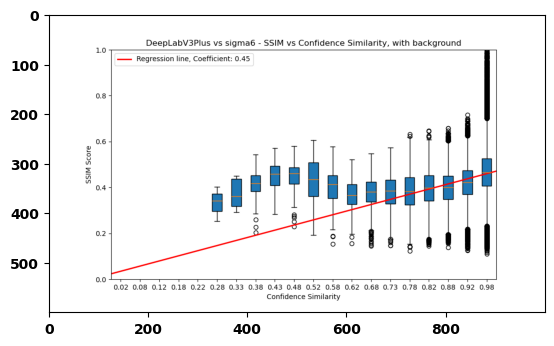

In [88]:
sigma = 6
image_1 = plt.imread(f'{plots_path_ssim}/{model}_sigma{sigma}_{metric}_vs_ssim.png')
plt.imshow(image_1)
plt.show()

In [89]:
# DeepLabV3
dlv3 =DeepLabV3Model(model_path=f'{ROOT}/models/torch_model_files/DeepLabV3_HybridFocalDiceLoss.pt')

# DeepLabV3Plus
dlv3p = DeepLabV3PlusModel(model_path=f'{ROOT}/models/torch_model_files/DeepLabV3Plus_HybridFocalDiceLoss.pt')

# UNet
unet = UNetModel(model_path=f'{ROOT}/models/torch_model_files/UNet_HybridFocalDiceLoss.pt')

# Pyramid Attention Network
pan = PyramidAttentionNetworkModel(model_path=f'{ROOT}/models/torch_model_files/PyramidAttentionNetwork_HybridFocalDiceLoss.pt')

# Pass a model to its corresponding ioU file
iou_paths = {
    dlv3: {
        'train': f'{ROOT}/res/model_performance/train_iou_dlv3.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_dlv3.h5'
    },
    dlv3p: {
        'train': f'{ROOT}/res/model_performance/train_iou_dlv3p.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_dlv3p.h5'
    },
    unet: {
        'train': f'{ROOT}/res/model_performance/train_iou_unet.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_unet.h5'
    },
    pan: {
        'train': f'{ROOT}/res/model_performance/train_iou_pan.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_pan.h5'
    }
}

# Confidence paths
confidence_paths = {
    dlv3: {
            'train': f'{ROOT}/res/confidence_vectors/dlv3_with_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/dlv3_with_bg_val.h5'
    },
    dlv3p: {
            'train': f'{ROOT}/res/confidence_vectors/dlv3p_with_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/dlv3p_with_bg_val.h5'
    },
    unet: {
            'train': f'{ROOT}/res/confidence_vectors/unet_with_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/unet_with_bg_val.h5'
    },
    pan: {
            'train': f'{ROOT}/res/confidence_vectors/pan_with_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/pan_with_bg_val.h5'
    }
}

2024-12-28 22:45:23,359 - DeepLabV3 - INFO - Device used for model: cuda
2024-12-28 22:45:23,899 - DeepLabV3Plus - INFO - Device used for model: cuda
2024-12-28 22:45:24,470 - UNet - INFO - Device used for model: cuda
2024-12-28 22:45:25,017 - PyramidAttentionNetwork - INFO - Device used for model: cuda


# Note

- Different k values tested -> it gets worse when k is low. So `always use k=256!`

In [90]:
k_means_model = 'k_means_model_k256_sift'
gmm_model = 'gmm_model_k256_sift'
chosen_model = dlv3
sigma = 10
# TODO: check if VLAD/Fisher cosine similarities and SSIM/MS-SSIM are correlated
vlad_train_data = load_hdf5(f'{ROOT}/res/vlad/train/{k_means_model}.h5')
vlad_val_data = load_hdf5(f'{ROOT}/res/vlad/validation/{k_means_model}.h5')
fisher_train_data = load_hdf5(f'{ROOT}/res/fisher/train/{gmm_model}.h5')
fisher_val_data = load_hdf5(f'{ROOT}/res/fisher/validation/{gmm_model}.h5')
ssim_data = load_hdf5(f'{ROOT}/res/ssim/train_vs_val/ssim_sigma{sigma}.h5')
iou_train = load_hdf5(iou_paths[chosen_model]['train'])
iou_test = load_hdf5(iou_paths[chosen_model]['val'])
conf_train = load_hdf5(confidence_paths[chosen_model]['train'])
conf_val = load_hdf5(confidence_paths[chosen_model]['val'])
train_paths_ssim = [path.decode('utf-8') for path in ssim_data['train_paths']]
val_paths_ssim = [path.decode('utf-8') for path in ssim_data['val_paths']]

### Reorganize data

Just to make sure all results are stored in the same order.

In [91]:

vlad_train_data = {path: vlad_train_data[path] for path in train_paths_ssim}
vlad_val_data = {path: vlad_val_data[path] for path in val_paths_ssim}
fisher_train_data = {path: fisher_train_data[path] for path in train_paths_ssim}
fisher_val_data = {path: fisher_val_data[path] for path in val_paths_ssim}
conf_train_data = {path: conf_train[path] for path in train_paths_ssim}
conf_val_data = {path: conf_val[path] for path in val_paths_ssim}
iou_train = {path: iou_train[path] for path in train_paths_ssim}
iou_test = {path: iou_test[path] for path in val_paths_ssim}

assert list(vlad_train_data.keys()) == train_paths_ssim
assert list(vlad_val_data.keys()) == val_paths_ssim
assert list(fisher_train_data.keys()) == train_paths_ssim
assert list(fisher_val_data.keys()) == val_paths_ssim
assert list(conf_train_data.keys()) == train_paths_ssim
assert list(conf_val_data.keys()) == val_paths_ssim
assert list(iou_train.keys()) == train_paths_ssim
assert list(iou_test.keys()) == val_paths_ssim

## Precompute all data necessary for analysis

Since the data is organized in correct order, we can flatten the matriceses.

In [92]:
train_imgs = list(vlad_train_data.keys())
val_imgs = list(vlad_val_data.keys())
vlad_train_vectors = np.array(list(vlad_train_data.values()))
vlad_val_vectors = np.array(list(vlad_val_data.values()))
vlad_matrix = cosine_similarity(vlad_val_vectors, vlad_train_vectors).flatten()
vlad_matrix = ((vlad_matrix+ 1) / 2).clip(0, 1) # Normalize to 0-1
fisher_train_vectors = np.array(list(fisher_train_data.values()))
fisher_val_vectors = np.array(list(fisher_val_data.values()))
fisher_matrix = cosine_similarity(fisher_val_vectors, fisher_train_vectors).flatten()
fisher_matrix = ((fisher_matrix + 1) / 2).clip(0, 1) # Normalize to 0-1
ssim_matrix = np.array(ssim_data['ssim']).flatten()
conf_train_vectors = np.array(list(conf_train_data.values()))
conf_val_vectors = np.array(list(conf_val_data.values()))
iou_diff = np.abs((np.array(list(iou_train.values())).reshape(1, -1) - np.array(list(iou_test.values())).reshape(-1, 1)).flatten())

conf_similarity = cosine_similarity(conf_val_vectors, conf_train_vectors).flatten()

From Plot: VLAD and SSIM does not correlate!  -> It's legitimate to combine these two features.

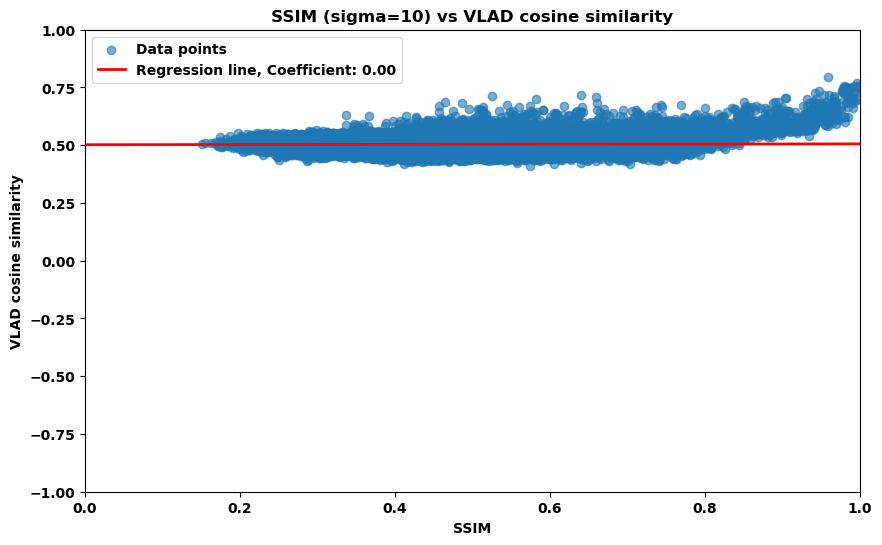

In [93]:
plot_scatter_with_regression(x=ssim_matrix.flatten(), y=vlad_matrix.flatten(), x_label='SSIM', y_label='VLAD cosine similarity', title=f'SSIM (sigma={sigma}) vs VLAD cosine similarity', y_lim=(-1, 1))

**VLAD and Fisher** are strongly correlated, as expected -> `Combining these two features would not be beneficial.`

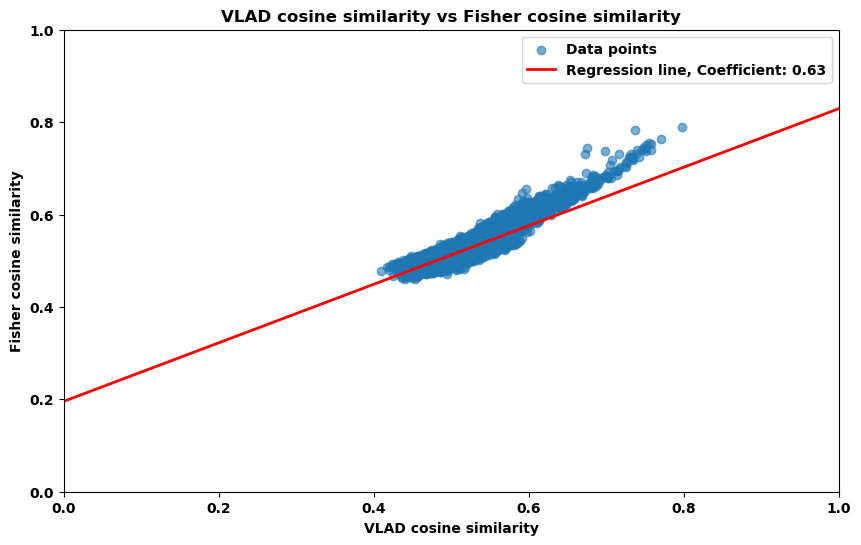

In [94]:
plot_scatter_with_regression(x=vlad_matrix, y=fisher_matrix, x_label='VLAD cosine similarity', y_label='Fisher cosine similarity', title=f'VLAD cosine similarity vs Fisher cosine similarity', y_lim=(0, 1))

# Plot histogram to see distribution

# a) VLAD

VLAD is more consistent than SSIM! (VLAD is adjusted to be centered around 0.5 in the histogram)

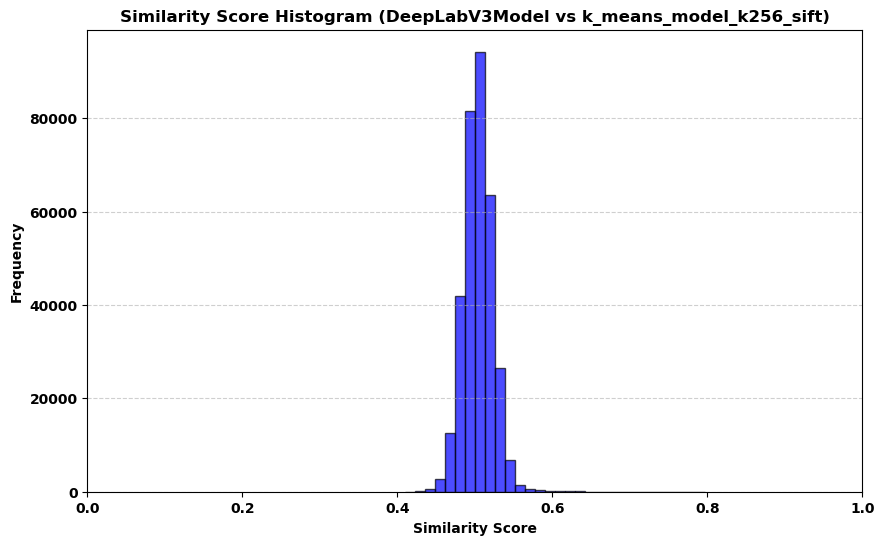

In [95]:

plot_and_save_histogram(vlad_matrix, num_bins=30, title=f"Similarity Score Histogram ({chosen_model.__class__.__name__} vs {k_means_model})", x_label="Similarity Score", y_label="Frequency")

# Fisher

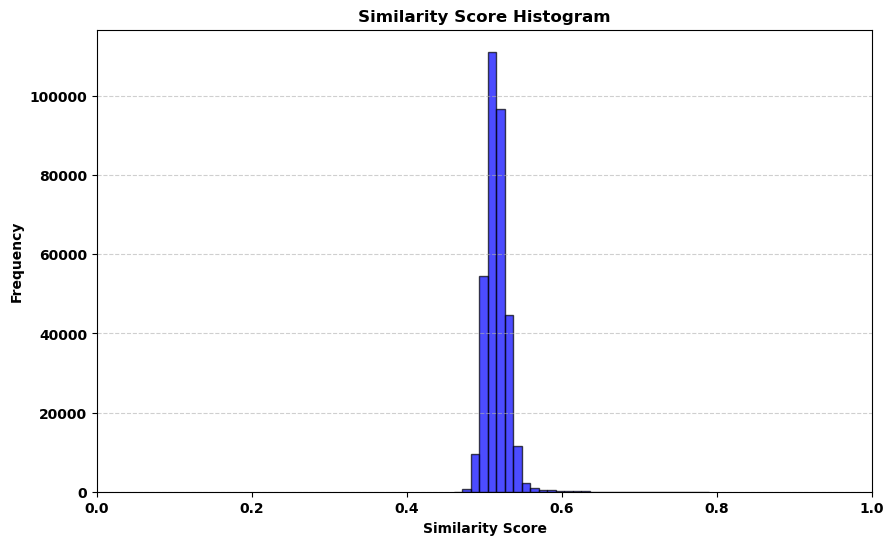

In [96]:
plot_and_save_histogram(fisher_matrix, num_bins=30, title=f"Similarity Score Histogram", x_label="Similarity Score", y_label="Frequency")

# b) SSIM

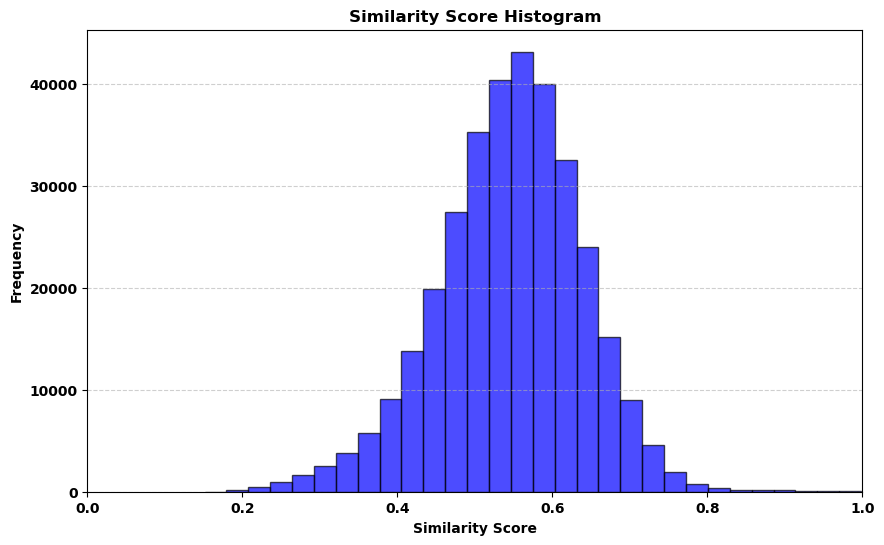

In [97]:
plot_and_save_histogram(ssim_matrix, num_bins=30, title=f"Similarity Score Histogram", x_label="Similarity Score", y_label="Frequency")

# c) IoU difference

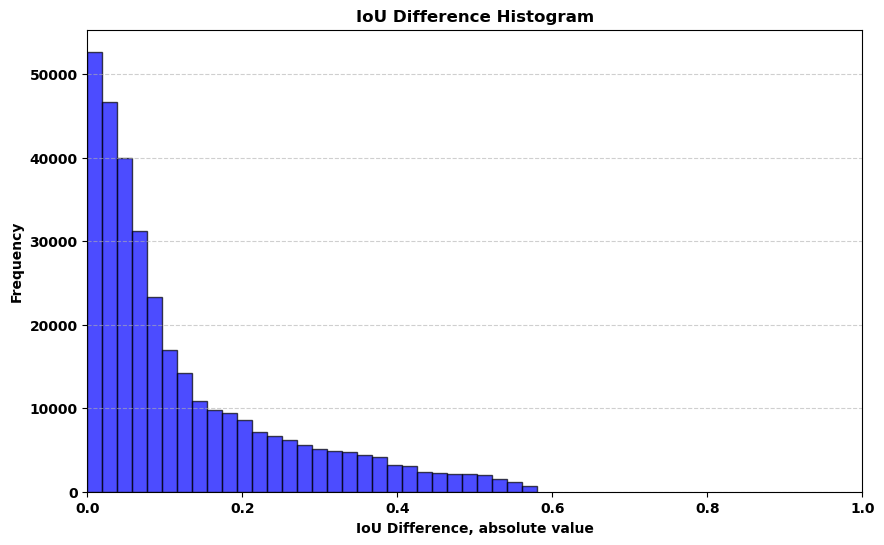

In [98]:
plot_and_save_histogram(iou_diff, num_bins=30, title=f"IoU Difference Histogram", x_label="IoU Difference, absolute value", y_label="Frequency")

d) confidence similarity

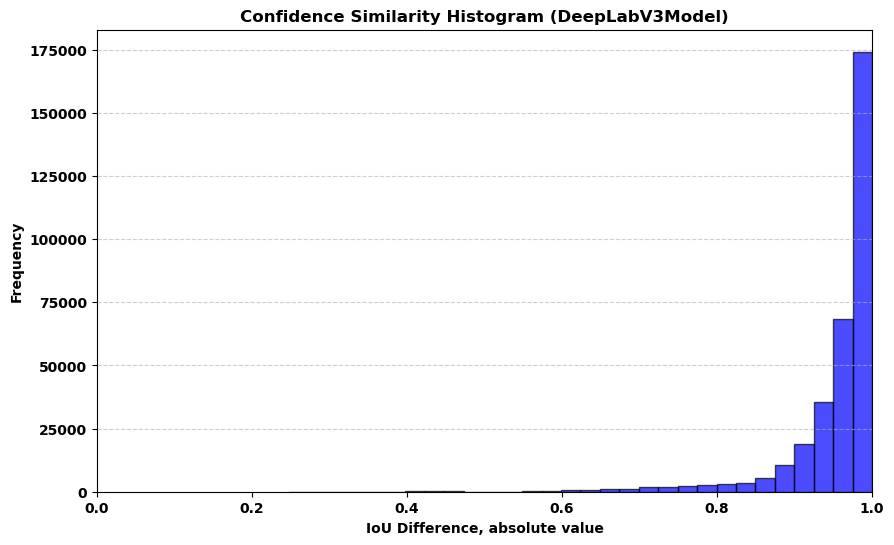

In [99]:
plot_and_save_histogram(conf_similarity, num_bins=30, title=f"Confidence Similarity Histogram ({chosen_model.__class__.__name__})", x_label="IoU Difference, absolute value", y_label="Frequency")

b) SSIM


                    Statistics of bin 1:
                      Pearson Correlation: -0.06
                      Spearman Correlation: -0.05
                      Standard Deviation: 0.09
                      Mean: 0.56
                      Median: 0.56
                      Number of Data Points: 197340
                      Regression Coefficients: -0.20
                      MSE: 0.0083
                    

                    Statistics of bin 2:
                      Pearson Correlation: -0.02
                      Spearman Correlation: -0.03
                      Standard Deviation: 0.09
                      Mean: 0.55
                      Median: 0.55
                      Number of Data Points: 61201
                      Regression Coefficients: -0.07
                      MSE: 0.0075
                    

                    Statistics of bin 3:
                      Pearson Correlation: -0.14
                      Spearman Correlation: -0.13
                      Standa

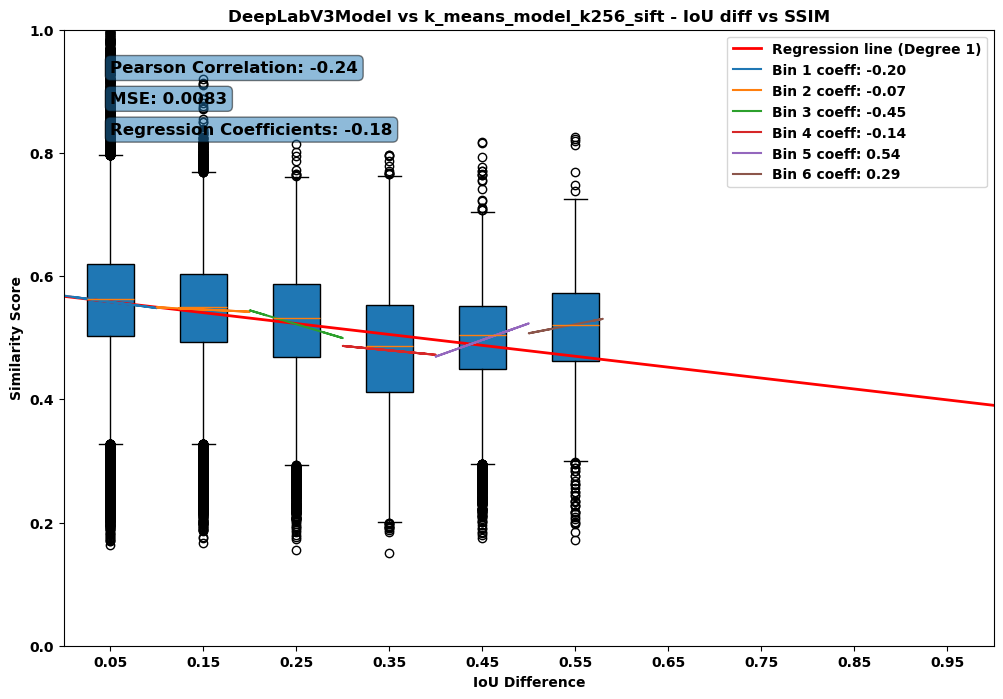

In [125]:
plot_boxplot_with_regression(y=np.array(ssim_matrix),
                                x=np.array(iou_diff),
                             poly_degree=1,
                                x_lim=(0, 1),
                                y_lim=(0, 1),
                                num_bins=10,
                                title=f"{chosen_model.__class__.__name__} vs {k_means_model} - IoU diff vs SSIM",
                             plot_bin_regression=True,
                             verbose=True)



# Combine VLAD and SSIM

In [101]:
weight_vlad, weight_ssim = 0.4, 0.6
combined_score = weight_vlad * vlad_matrix + weight_ssim * ssim_matrix


                    Statistics of bin 1:
                      Pearson Correlation: -0.07
                      Spearman Correlation: -0.06
                      Standard Deviation: 0.06
                      Mean: 0.54
                      Median: 0.54
                      Number of Data Points: 197340
                      Regression Coefficients: -0.13
                      MSE: 0.0031
                    

                    Statistics of bin 2:
                      Pearson Correlation: -0.02
                      Spearman Correlation: -0.02
                      Standard Deviation: 0.05
                      Mean: 0.53
                      Median: 0.53
                      Number of Data Points: 61201
                      Regression Coefficients: -0.04
                      MSE: 0.0027
                    

                    Statistics of bin 3:
                      Pearson Correlation: -0.14
                      Spearman Correlation: -0.13
                      Standa

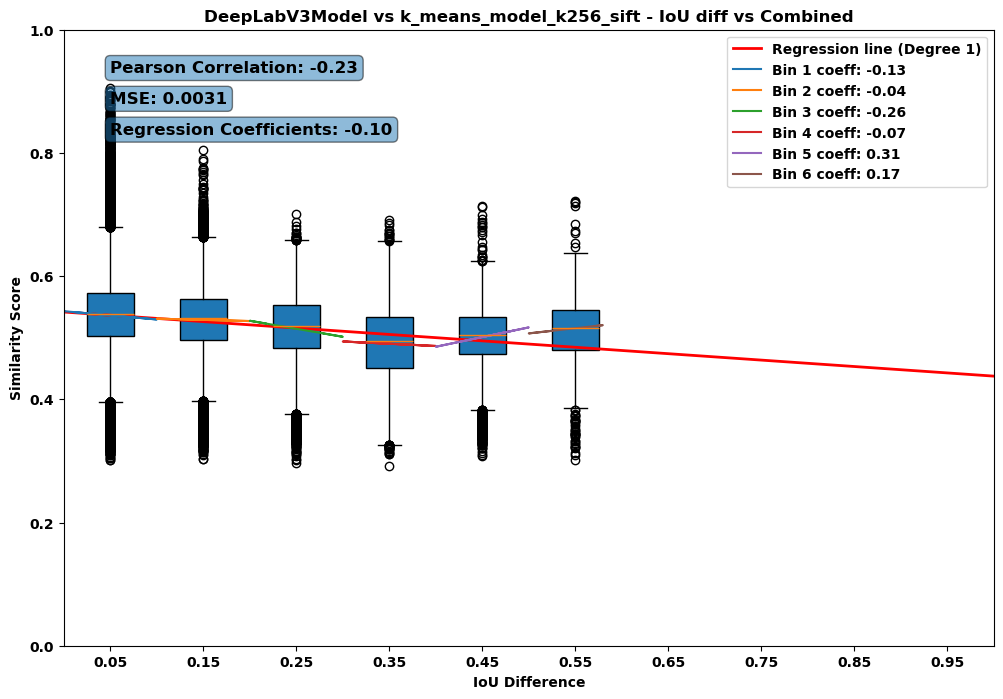

In [102]:
plot_boxplot_with_regression(y=np.array(combined_score),
                                x=np.array(iou_diff),
                             poly_degree=1,
                                x_lim=(0, 1),
                                y_lim=(0, 1),
                                 num_bins=10,
                                title=f"{chosen_model.__class__.__name__} vs {k_means_model} - IoU diff vs Combined",
                                plot_bin_regression=True,
                                verbose=True)

## Grid search to find the optimal weights for VLAD and SSIM

It seems like the combination works better than either of the features alone. Let's find the optimal weights for VLAD and SSIM.

### Step 1: Define Grid Search Parameters
Define the range of weights for VLAD and SSIM and the bins to consider.



                    Statistics of bin 3:
                      Pearson Correlation: 0.27
                      Spearman Correlation: 0.30
                      Standard Deviation: 0.02
                      Mean: 0.42
                      Median: 0.41
                      Number of Data Points: 5
                      Regression Coefficients: 0.28
                      MSE: 0.0003
                    

                    Statistics of bin 4:
                      Pearson Correlation: 0.31
                      Spearman Correlation: 0.18
                      Standard Deviation: 0.04
                      Mean: 0.51
                      Median: 0.51
                      Number of Data Points: 50
                      Regression Coefficients: 0.79
                      MSE: 0.0017
                    

                    Statistics of bin 5:
                      Pearson Correlation: -0.06
                      Spearman Correlation: 0.02
                      Standard Deviation: 0

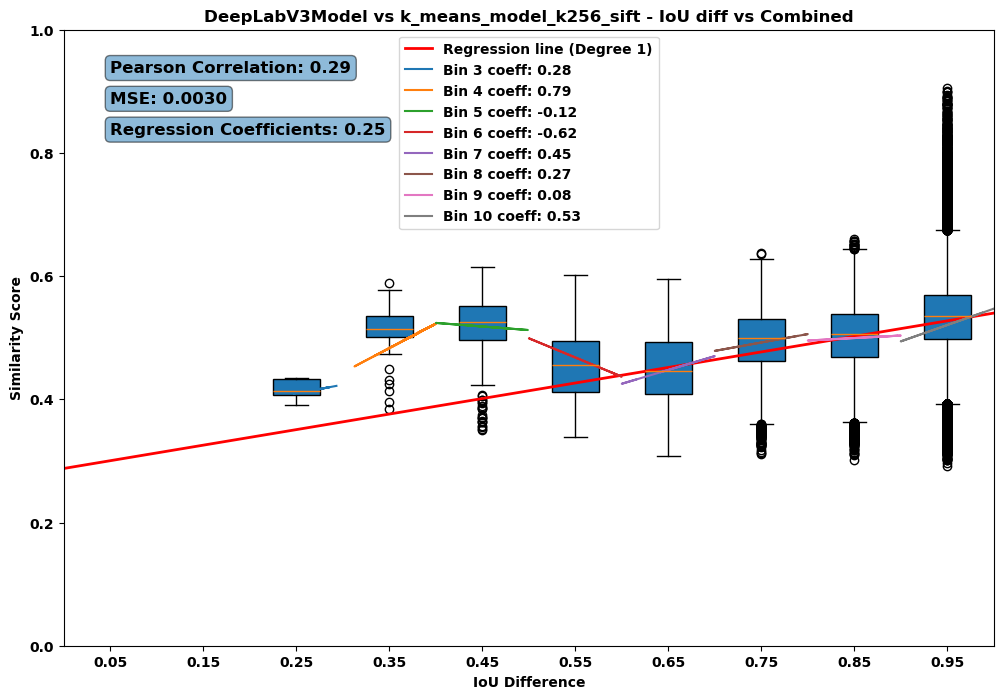

In [103]:
plot_boxplot_with_regression(y=combined_score,
                                x=conf_similarity,
                             poly_degree=1,
                                x_lim=(0, 1),
                                y_lim=(0, 1),
                                 num_bins=10,
                                title=f"{chosen_model.__class__.__name__} vs {k_means_model} - IoU diff vs Combined",
                                plot_bin_regression=True,
                                verbose=True)

In [104]:
weights_vlad = np.linspace(0, 1, 11)
weights_ssim = 1 - weights_vlad

bins_to_consider = [1, 2, 3, 4, 5]


### Step 2: Perform Grid Search
Loop through weight combinations and calculate the average of selected metrics across chosen bins.


In [105]:
def bin_and_calculate_correlation(x: np.ndarray, y: np.ndarray, num_bins: int = 20):
    bins = np.linspace(0, 1, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    correlations = []
    for i in range(num_bins):
        in_bin = (x >= bins[i]) & (x < bins[i + 1])
        if in_bin.sum() > 1:  # Ensure enough points
            corr, _ = pearsonr(x[in_bin], y[in_bin])
            correlations.append(corr)
        else:
            correlations.append(np.nan)
    return bin_centers, correlations


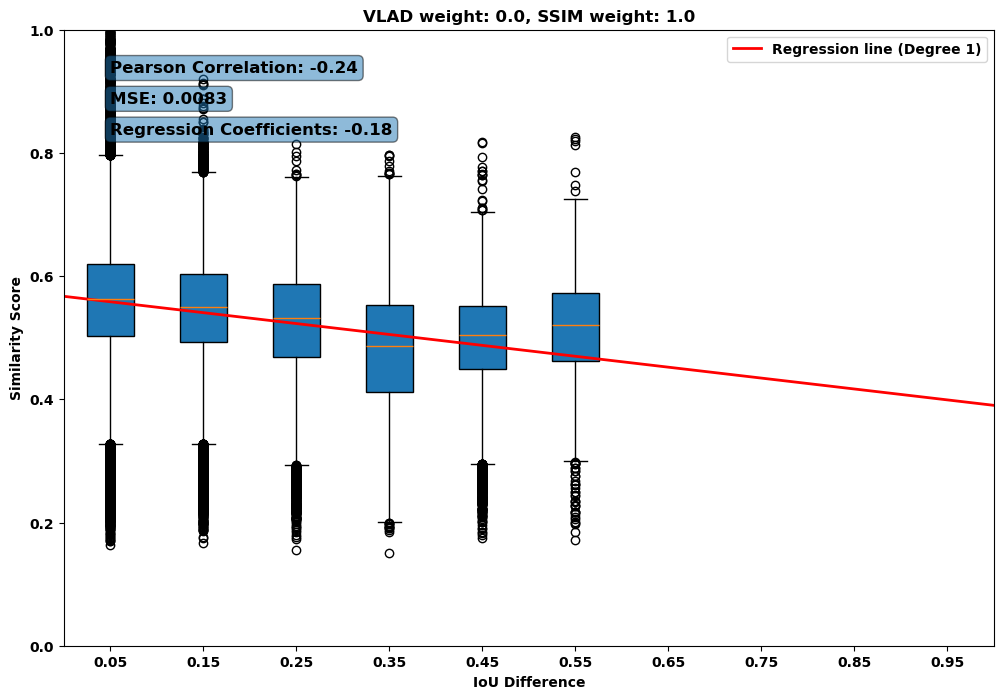

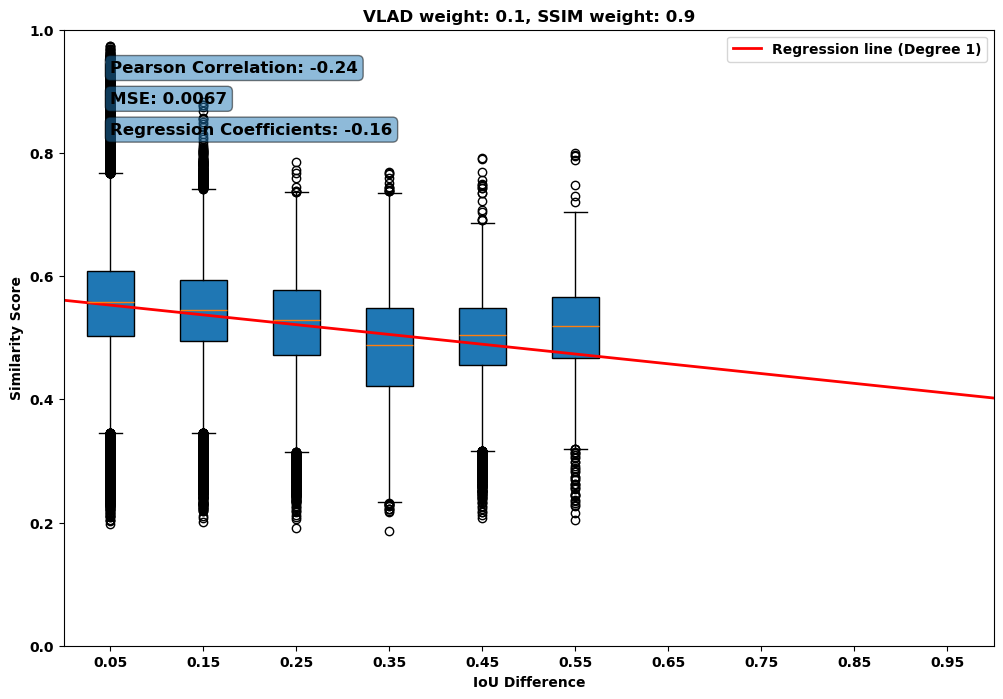

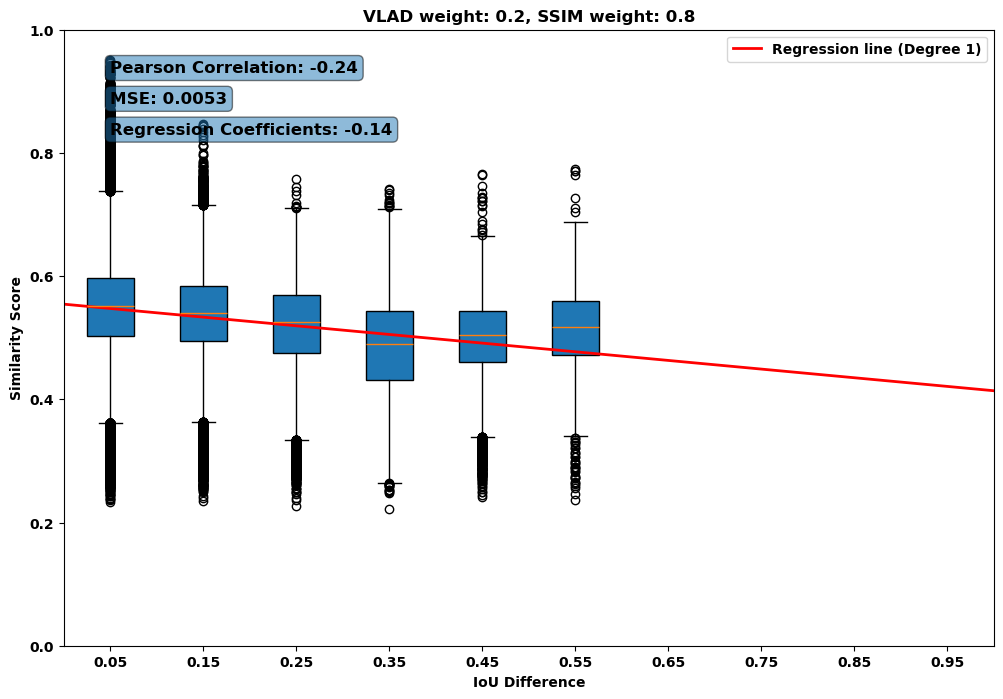

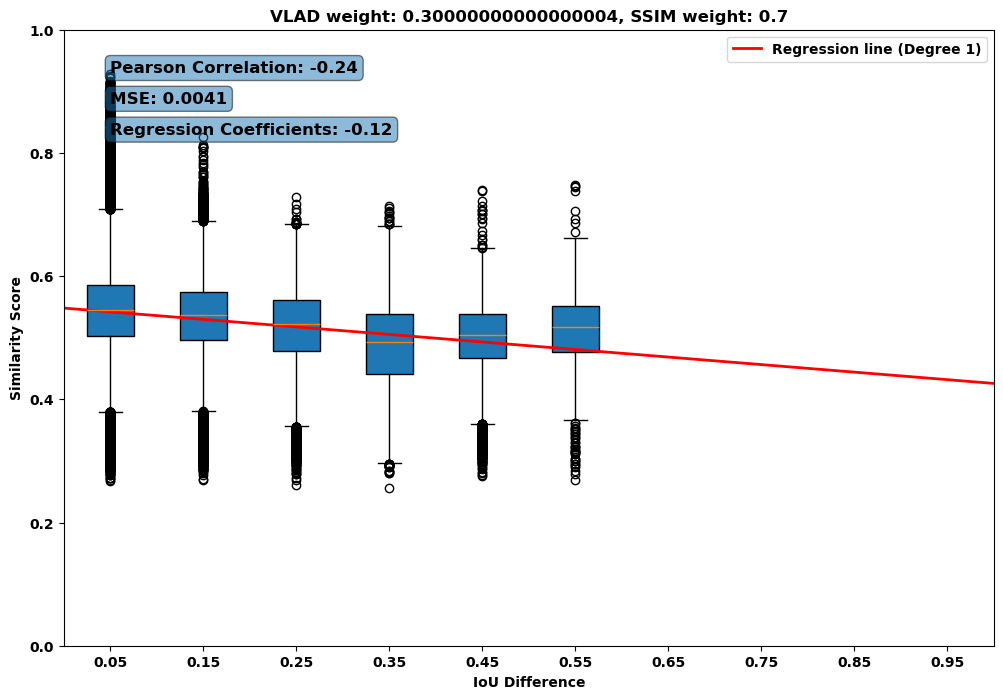

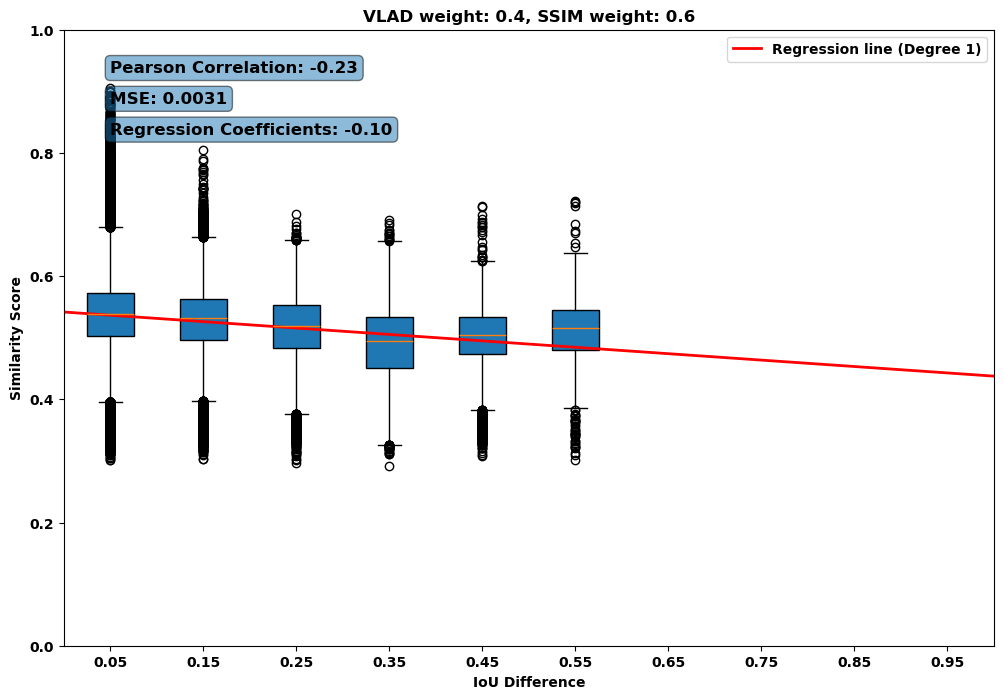

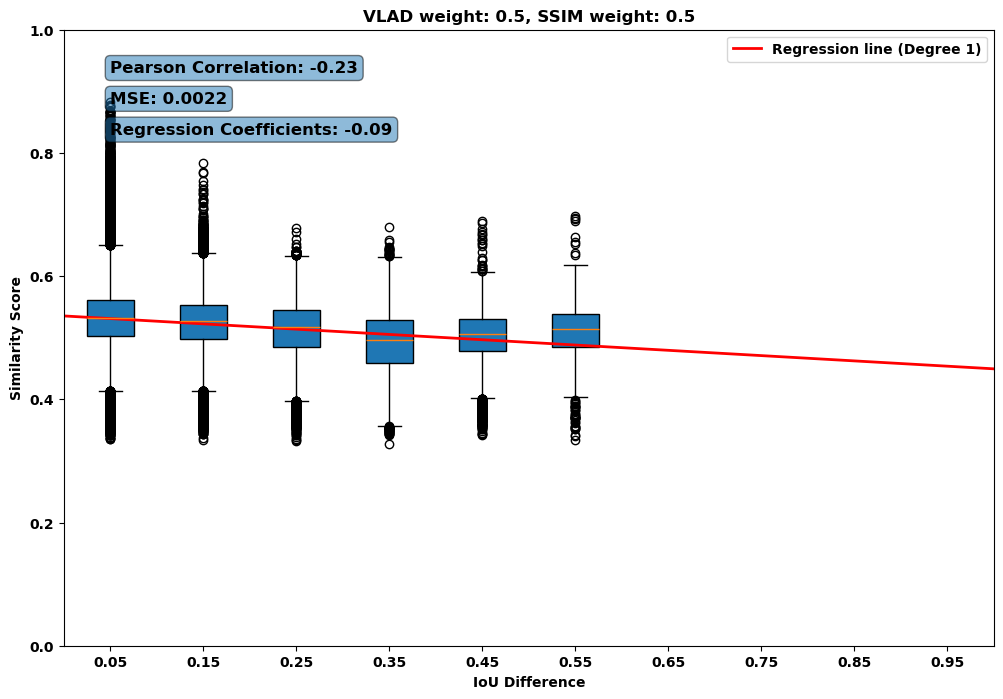

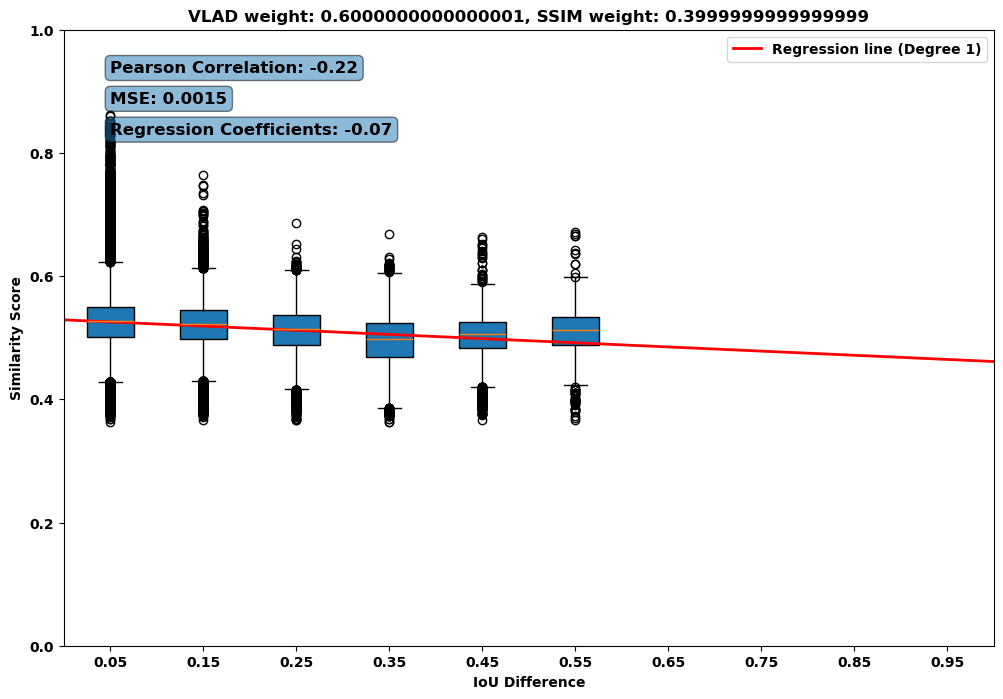

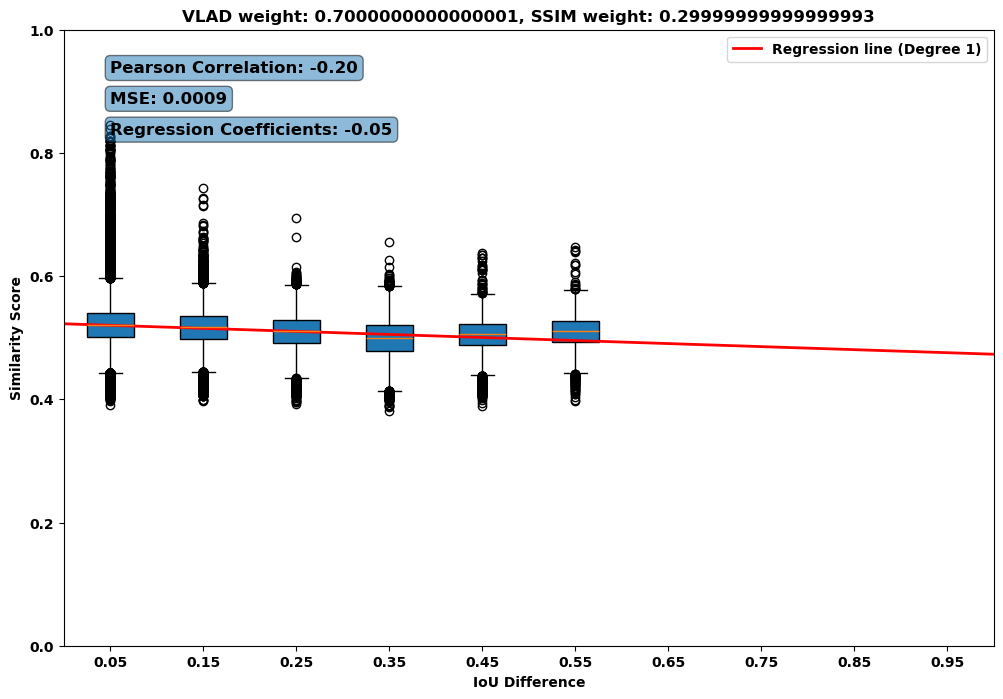

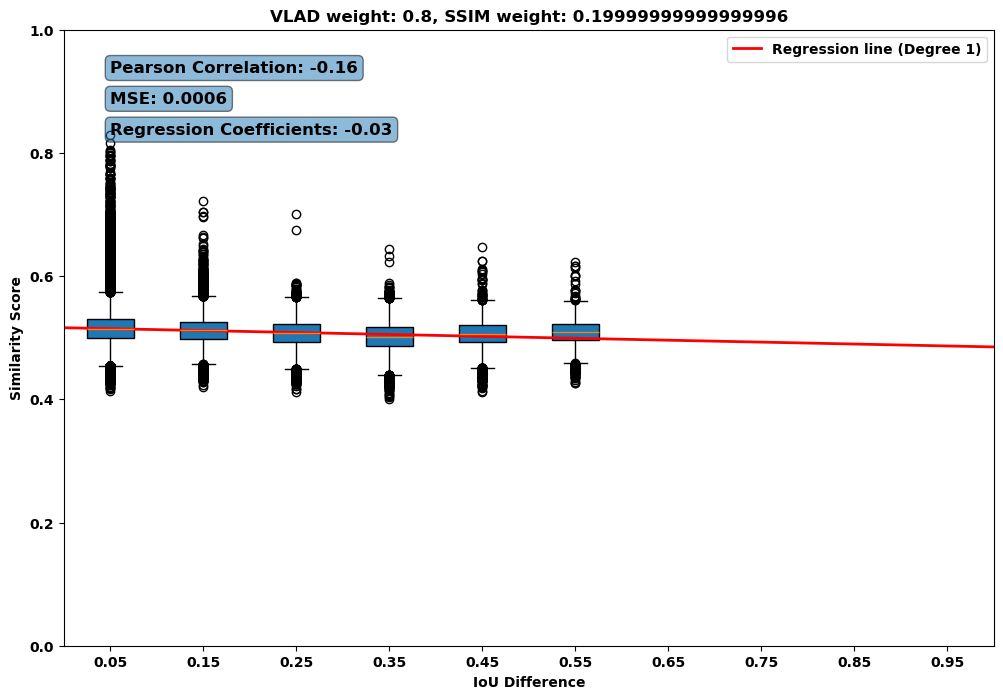

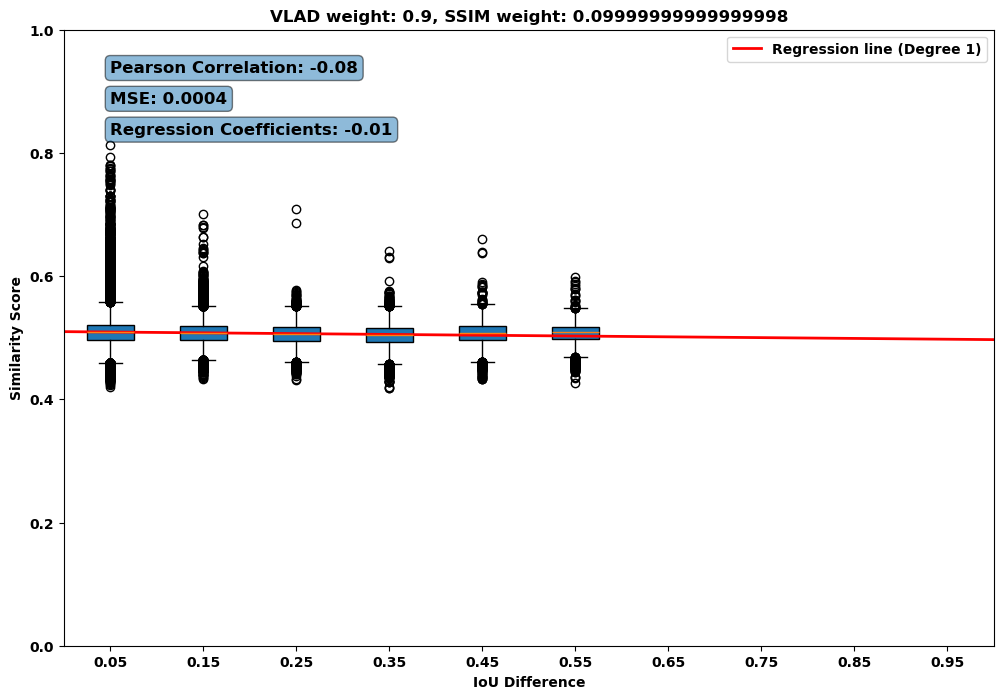

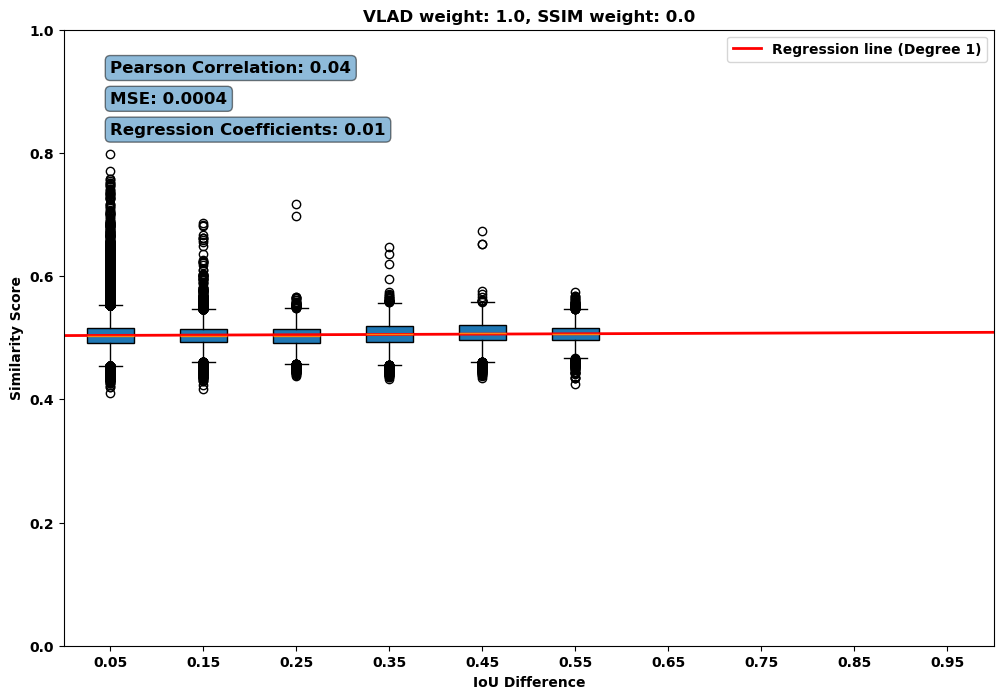

In [106]:
# Placeholder to store results
results = []

for w_vlad, w_ssim in zip(weights_vlad, weights_ssim):
    combined_score_new = w_vlad * vlad_matrix + w_ssim * ssim_matrix

    bin_centers, binned_y = bin_and_calculate_correlation(
        x=iou_diff, y=combined_score_new, num_bins=10
    )

    per_bin_results = plot_boxplot_with_regression(
        x=iou_diff, y=combined_score_new,
        poly_degree=1, num_bins=10, return_results=True,
        title=f"VLAD weight: {w_vlad}, SSIM weight: {w_ssim}",
        verbose=False
    )["per_bin_statistics"]

    # Filter results for chosen bins
    filtered_bins = [bin_stat for bin_stat in per_bin_results if bin_stat["bin_index"] in bins_to_consider]

    # Weighted averages
    total_points = sum(bin_stat["bin_stats"].n_points for bin_stat in filtered_bins)
    avg_mse = sum(bin_stat["regression"].mse * bin_stat["bin_stats"].n_points / total_points for bin_stat in filtered_bins)
    avg_pearson = sum(bin_stat["bin_stats"].pearson * bin_stat["bin_stats"].n_points / total_points for bin_stat in filtered_bins)
    avg_std = sum(bin_stat["bin_stats"].std * bin_stat["bin_stats"].n_points / total_points for bin_stat in filtered_bins)

    results.append({
        "w_vlad": w_vlad,
        "w_ssim": w_ssim,
        "avg_mse": avg_mse,
        "avg_pearson": avg_pearson,
        "avg_std": avg_std
    })


In [107]:

results_df = pd.DataFrame(results)

# Find the best combinations for each metric
best_mse = results_df.loc[results_df["avg_mse"].idxmin()]
best_pearson = results_df.loc[results_df["avg_pearson"].idxmax()]
best_std = results_df.loc[results_df["avg_std"].idxmin()]

print("Best weights for MSE:", best_mse)
print("Best weights for Pearson Correlation:", best_pearson)
print("Best weights for Standard Deviation:", best_std)

# Find the overall best combination (weighted average of metrics)
results_df["avg_combined"] = results_df[["avg_mse", "avg_pearson", "avg_std"]].mean(axis=1)
best_combined = results_df.loc[results_df["avg_combined"].idxmax()]

print("Best overall combination:", best_combined)


Best weights for MSE: w_vlad         1.000000
w_ssim         0.000000
avg_mse        0.000359
avg_pearson   -0.017059
avg_std        0.018903
Name: 10, dtype: float64
Best weights for Pearson Correlation: w_vlad         1.000000
w_ssim         0.000000
avg_mse        0.000359
avg_pearson   -0.017059
avg_std        0.018903
Name: 10, dtype: float64
Best weights for Standard Deviation: w_vlad         1.000000
w_ssim         0.000000
avg_mse        0.000359
avg_pearson   -0.017059
avg_std        0.018903
Name: 10, dtype: float64
Best overall combination: w_vlad          0.000000
w_ssim          1.000000
avg_mse         0.008222
avg_pearson    -0.051245
avg_std         0.090862
avg_combined    0.015946
Name: 0, dtype: float64


# Implement the same thing for confidence vectors

## Note:
Almost 90% of data points are concentrated in the last bin! (0.9-1.0). See the `print` messages in the code below.

a) SSIM


                    Statistics of bin 3:
                      Pearson Correlation: 0.28
                      Spearman Correlation: 0.30
                      Standard Deviation: 0.03
                      Mean: 0.34
                      Median: 0.34
                      Number of Data Points: 5
                      Regression Coefficients: 0.52
                      MSE: 0.0008
                    

                    Statistics of bin 4:
                      Pearson Correlation: 0.32
                      Spearman Correlation: 0.19
                      Standard Deviation: 0.08
                      Mean: 0.50
                      Median: 0.52
                      Number of Data Points: 50
                      Regression Coefficients: 1.42
                      MSE: 0.0051
                    

                    Statistics of bin 5:
                      Pearson Correlation: -0.03
                      Spearman Correlation: 0.07
                      Standard Deviation: 0

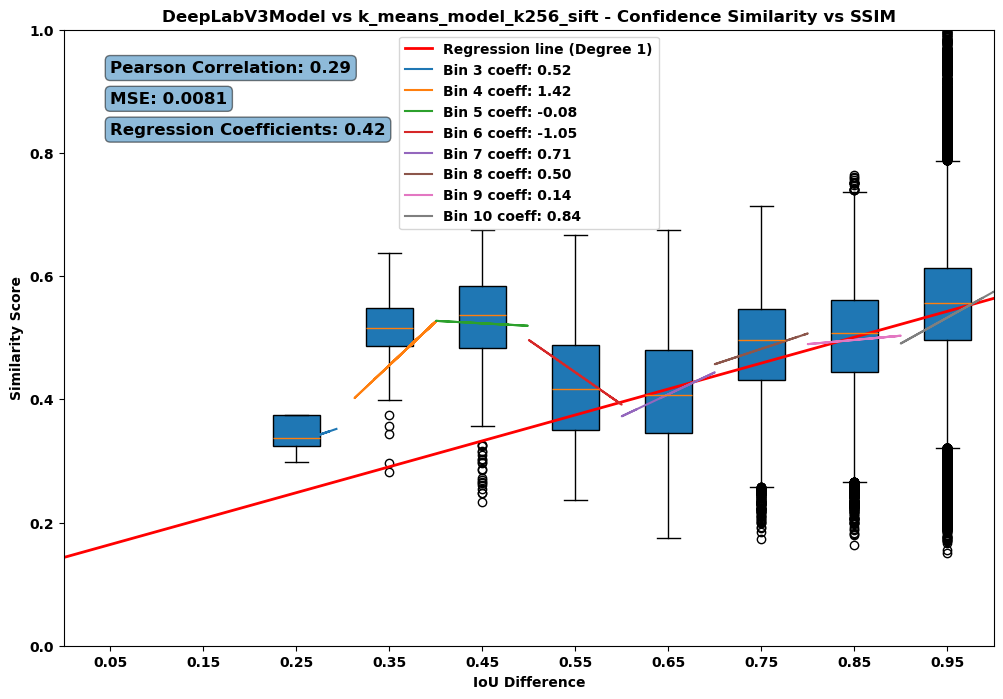

In [122]:
plot_boxplot_with_regression(y=ssim_matrix,
                                x=conf_similarity,
                             poly_degree=1,
                                x_lim=(0, 1),
                                y_lim=(0, 1),
                                num_bins=10,
                                title=f"{chosen_model.__class__.__name__} vs {k_means_model} - Confidence Similarity vs SSIM",
                             plot_bin_regression=True,
                             verbose=True)


b) Combined


                    Statistics of bin 3:
                      Pearson Correlation: 0.27
                      Spearman Correlation: 0.30
                      Standard Deviation: 0.02
                      Mean: 0.42
                      Median: 0.41
                      Number of Data Points: 5
                      Regression Coefficients: 0.28
                      MSE: 0.0003
                    

                    Statistics of bin 4:
                      Pearson Correlation: 0.31
                      Spearman Correlation: 0.18
                      Standard Deviation: 0.04
                      Mean: 0.51
                      Median: 0.51
                      Number of Data Points: 50
                      Regression Coefficients: 0.79
                      MSE: 0.0017
                    

                    Statistics of bin 5:
                      Pearson Correlation: -0.06
                      Spearman Correlation: 0.02
                      Standard Deviation: 0

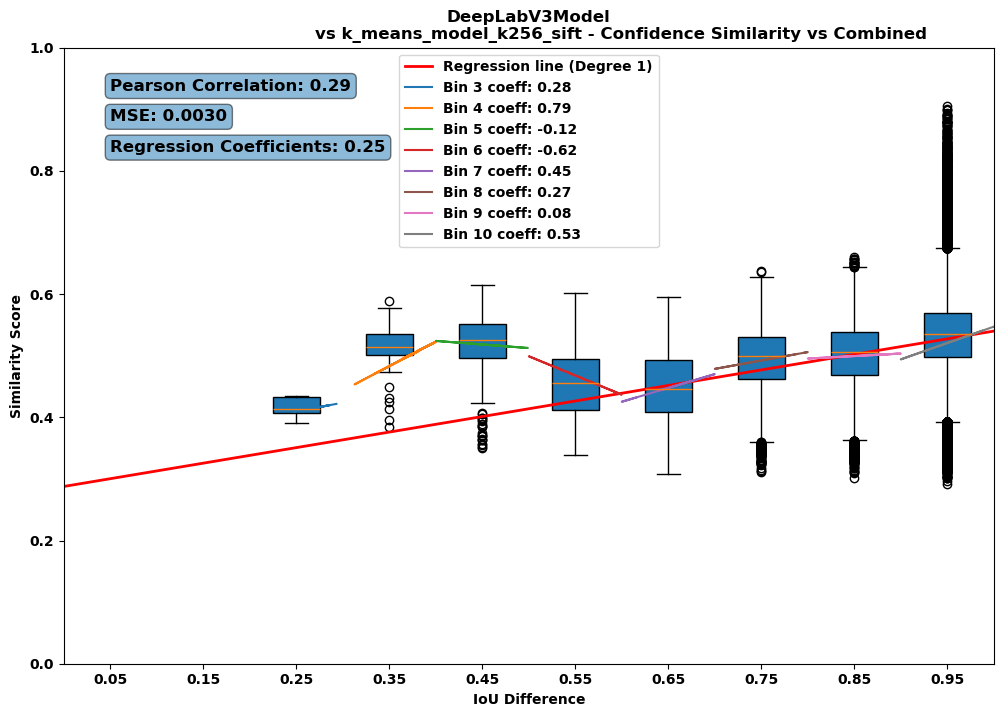

In [119]:
weight_vlad, weight_ssim = 0.4, 0.6
combined_score = weight_vlad * vlad_matrix + weight_ssim * ssim_matrix

plot_boxplot_with_regression(y=np.array(combined_score),
                                x=np.array(conf_similarity),
                             poly_degree=1,
                                x_lim=(0, 1),
                                y_lim=(0, 1),
                                 num_bins=10,
                                title=f"""{chosen_model.__class__.__name__}
                                vs {k_means_model} - Confidence Similarity vs Combined""",
                                plot_bin_regression=True,
                                verbose=True)

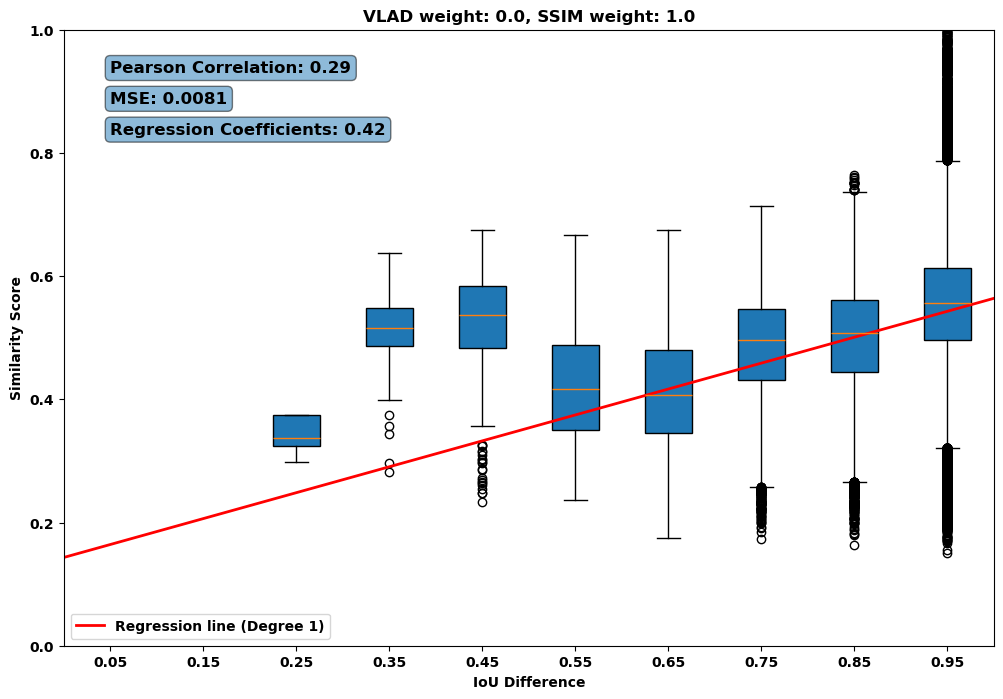


    Weighted averages for VLAD weight: 0.0, SSIM weight: 1.0
    - MSE: 0.00790007676985656
    - Pearson: 0.21251785075945048
    - STD: 0.09108755585039807
    


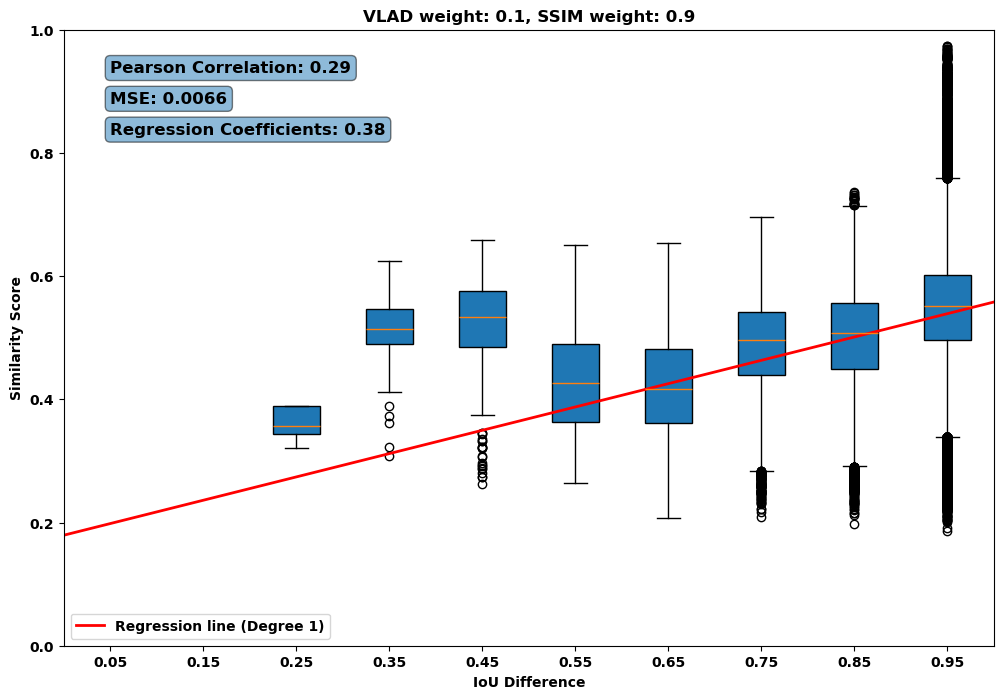


    Weighted averages for VLAD weight: 0.1, SSIM weight: 0.9
    - MSE: 0.006405007467567897
    - Pearson: 0.21402119013634535
    - STD: 0.08204779944200276
    


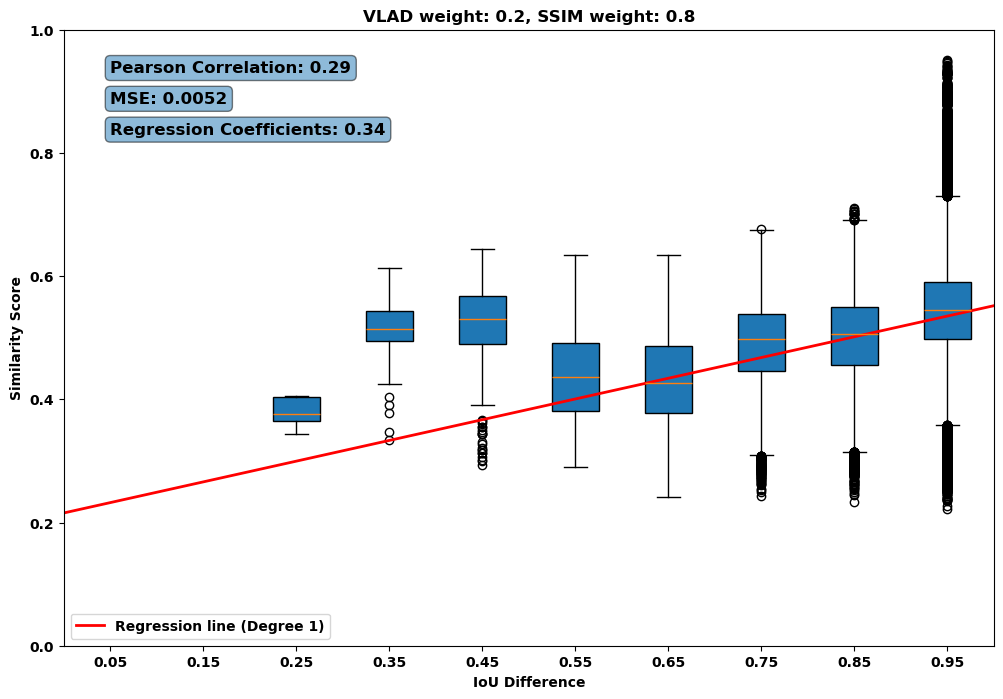


    Weighted averages for VLAD weight: 0.2, SSIM weight: 0.8
    - MSE: 0.005074539588205217
    - Pearson: 0.2157327566377613
    - STD: 0.07306248728574692
    


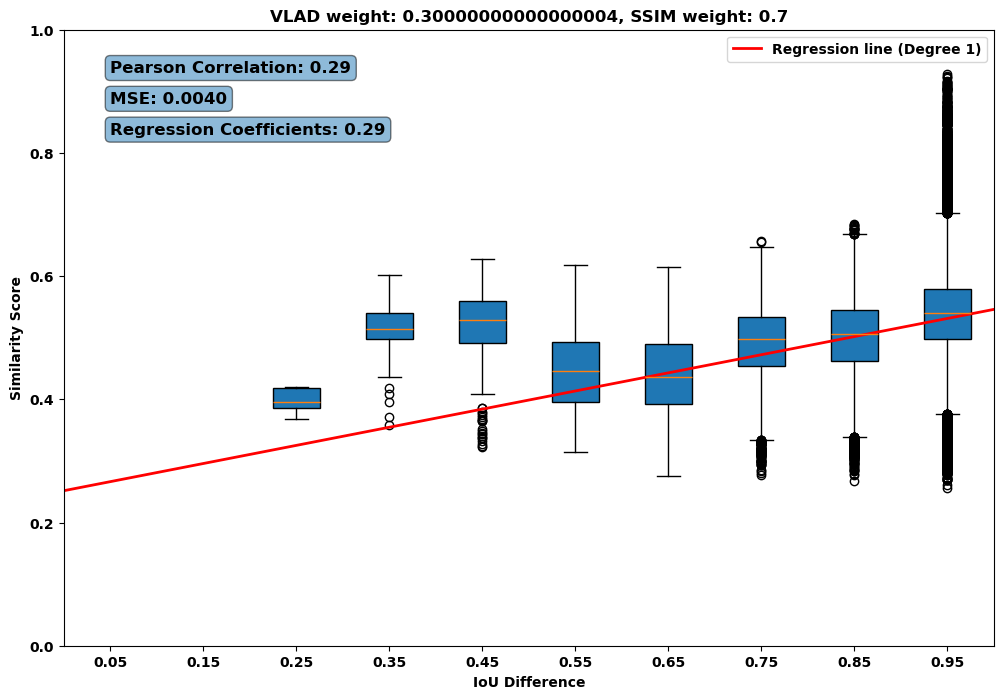


    Weighted averages for VLAD weight: 0.30000000000000004, SSIM weight: 0.7
    - MSE: 0.003908671582774788
    - Pearson: 0.2176568495389351
    - STD: 0.06415447659767297
    


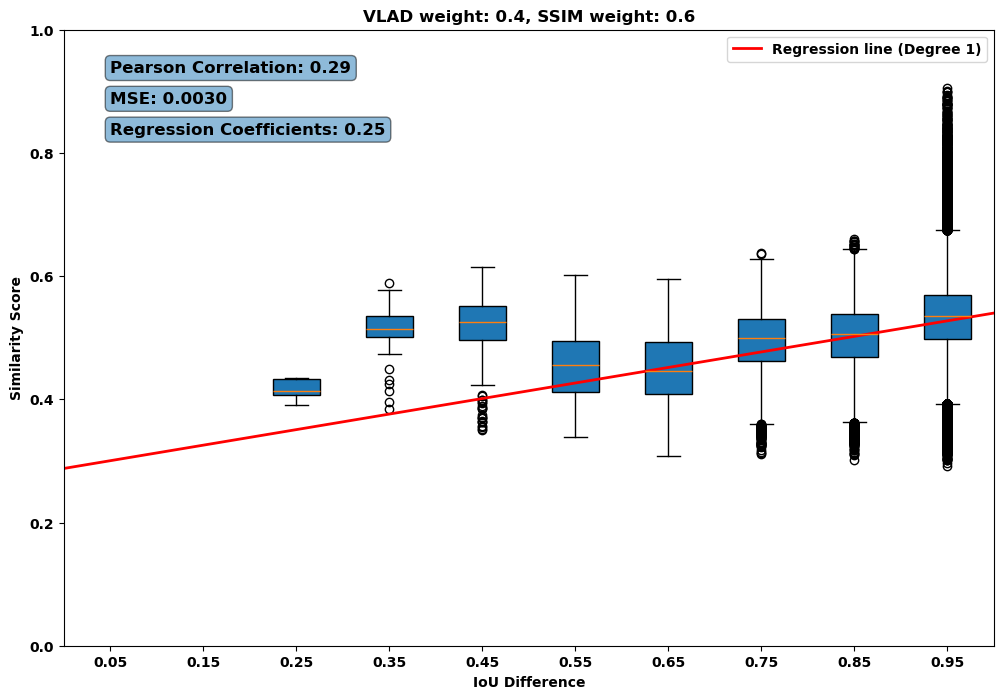


    Weighted averages for VLAD weight: 0.4, SSIM weight: 0.6
    - MSE: 0.002907404874593339
    - Pearson: 0.21973783370585592
    - STD: 0.05536109172372344
    


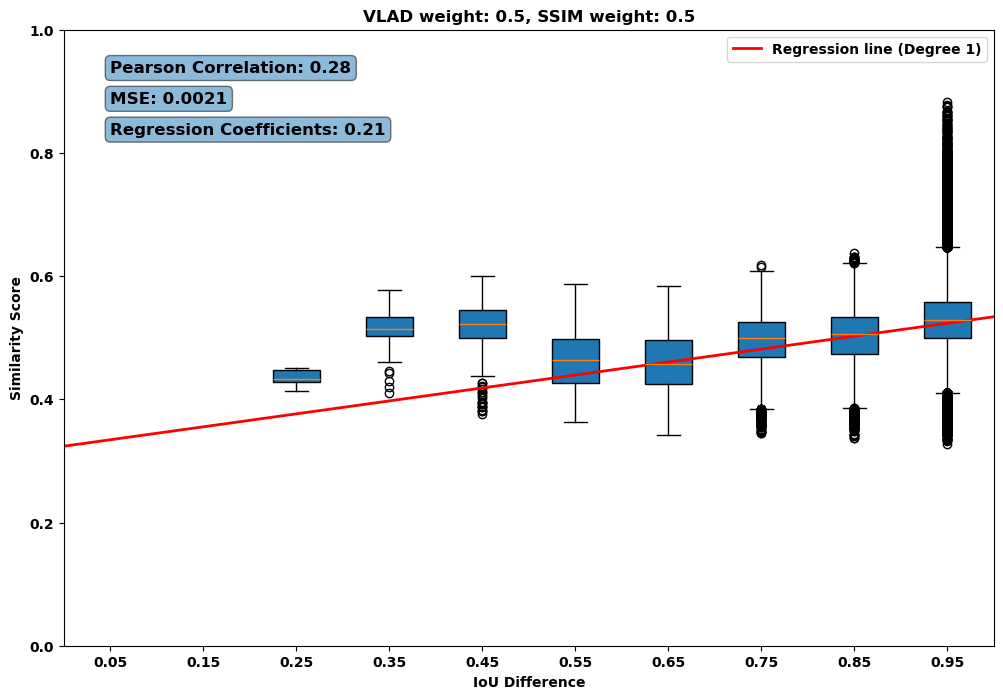


    Weighted averages for VLAD weight: 0.5, SSIM weight: 0.5
    - MSE: 0.0020707382963597214
    - Pearson: 0.22173856090780966
    - STD: 0.04674702121998967
    


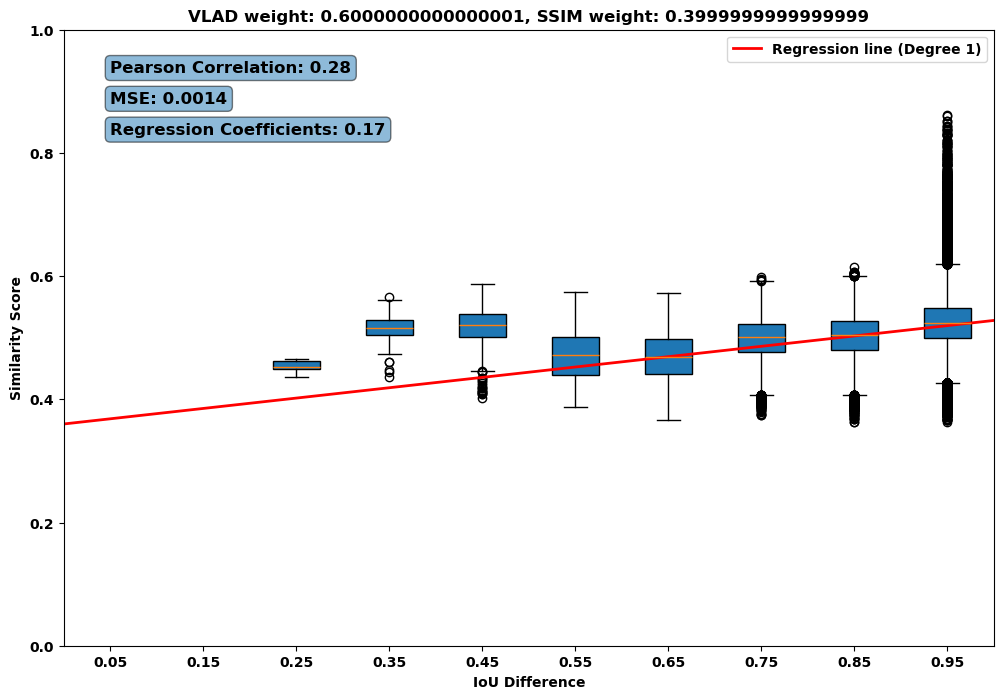


    Weighted averages for VLAD weight: 0.6000000000000001, SSIM weight: 0.3999999999999999
    - MSE: 0.0013986726732834933
    - Pearson: 0.2228709509533101
    - STD: 0.03843299740663557
    


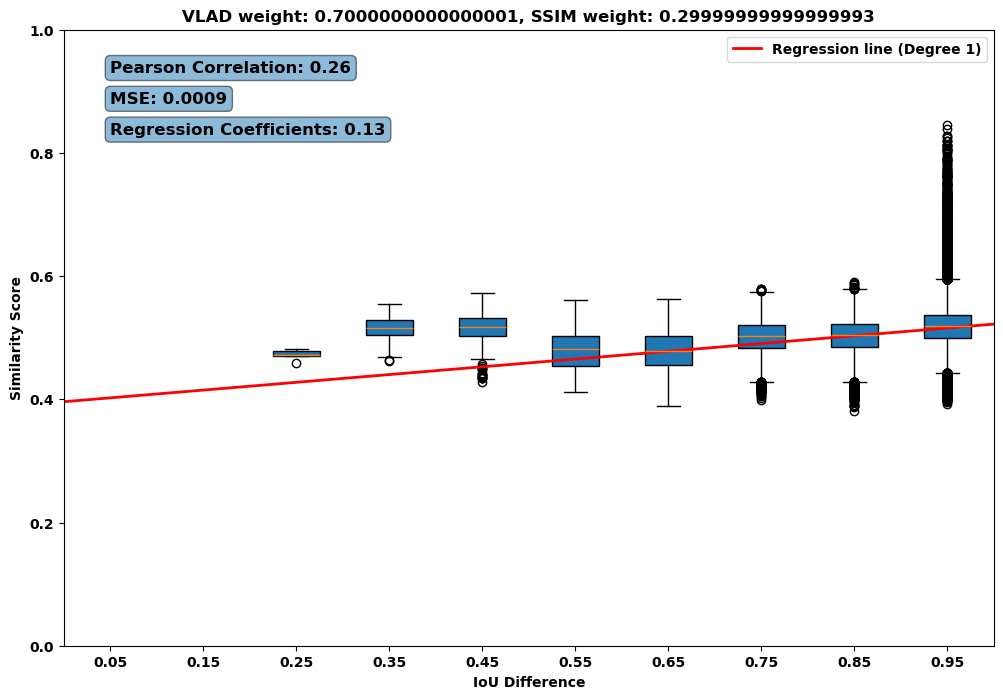


    Weighted averages for VLAD weight: 0.7000000000000001, SSIM weight: 0.29999999999999993
    - MSE: 0.0008912076664513949
    - Pearson: 0.22061789505108703
    - STD: 0.03066406279294784
    


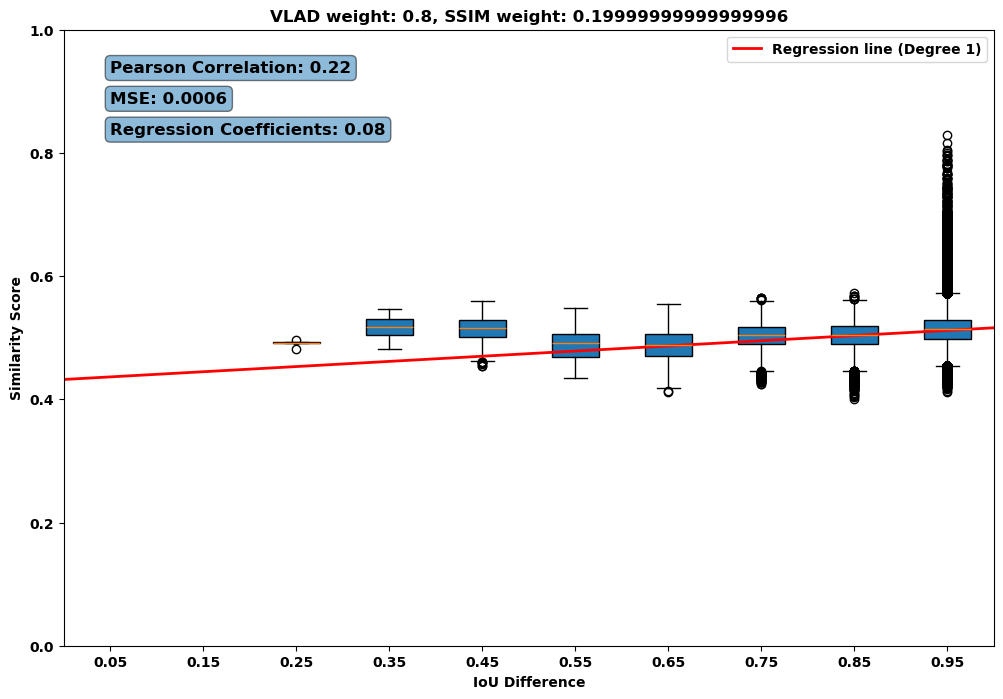


    Weighted averages for VLAD weight: 0.8, SSIM weight: 0.19999999999999996
    - MSE: 0.0005483432872100053
    - Pearson: 0.20711239019943017
    - STD: 0.02397664180249918
    


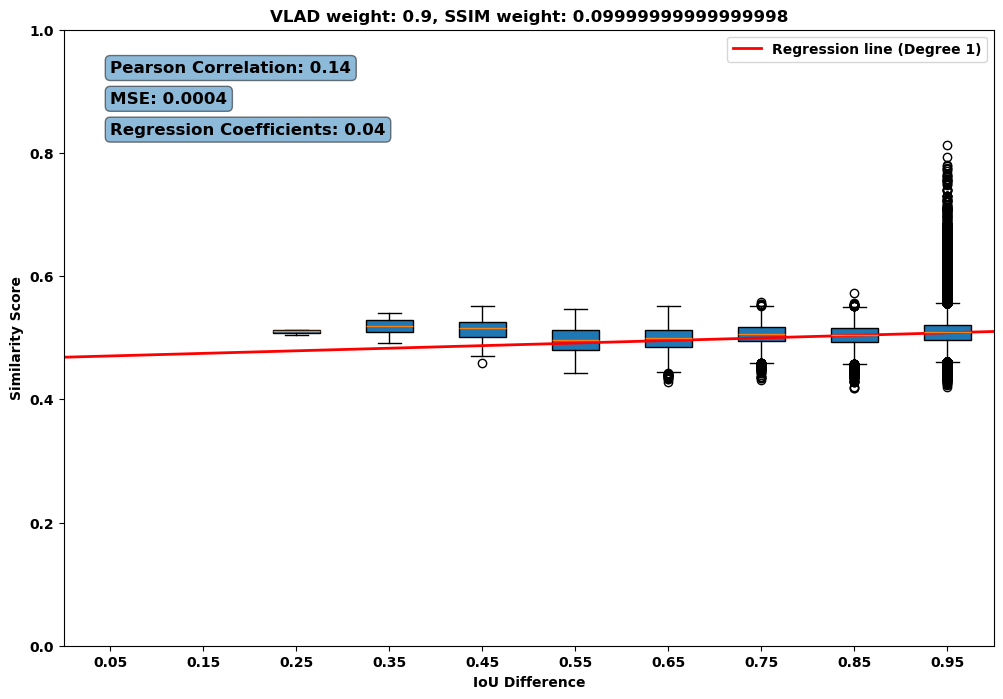


    Weighted averages for VLAD weight: 0.9, SSIM weight: 0.09999999999999998
    - MSE: 0.00037007961202010483
    - Pearson: 0.16270186459217986
    - STD: 0.019519191620393464
    


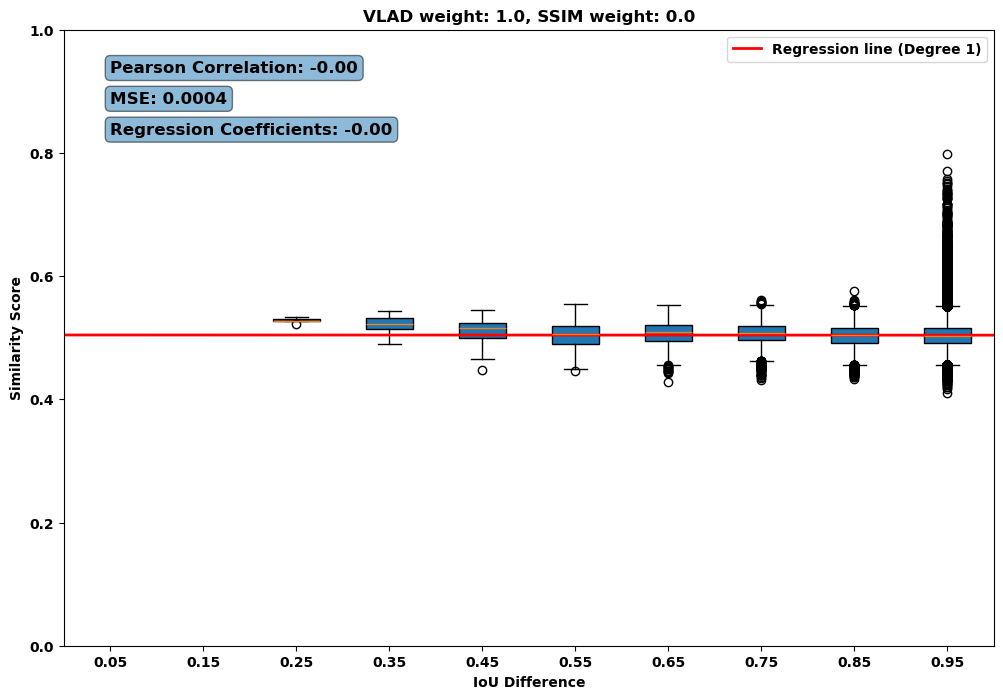


    Weighted averages for VLAD weight: 1.0, SSIM weight: 0.0
    - MSE: 0.0003564166153947668
    - Pearson: 0.07397311708046078
    - STD: 0.01894017557692717
    


In [121]:
# Placeholder to store results
bins_to_consider = [6, 7, 8, 9, 10]
results = []

for w_vlad, w_ssim in zip(weights_vlad, weights_ssim):
    combined_score_new = w_vlad * vlad_matrix + w_ssim * ssim_matrix

    bin_centers, binned_y = bin_and_calculate_correlation(
        x=conf_similarity, y=combined_score_new, num_bins=10
    )

    per_bin_results = plot_boxplot_with_regression(
        x=conf_similarity,
        y=combined_score_new,
        poly_degree=1, num_bins=10, return_results=True,
        title=f"VLAD weight: {w_vlad}, SSIM weight: {w_ssim}",
        verbose=False
    )["per_bin_statistics"]

    # Filter results for chosen bins
    filtered_bins = [bin_stat for bin_stat in per_bin_results if bin_stat["bin_index"] in bins_to_consider]

    # Weighted averages
    total_points = sum(bin_stat["bin_stats"].n_points for bin_stat in filtered_bins)
    avg_mse = sum(bin_stat["regression"].mse * bin_stat["bin_stats"].n_points / total_points for bin_stat in filtered_bins)
    avg_pearson = sum(bin_stat["bin_stats"].pearson * bin_stat["bin_stats"].n_points / total_points for bin_stat in filtered_bins)
    avg_std = sum(bin_stat["bin_stats"].std * bin_stat["bin_stats"].n_points / total_points for bin_stat in filtered_bins)

    print(f"""
    Weighted averages for VLAD weight: {w_vlad}, SSIM weight: {w_ssim}
    - MSE: {avg_mse}
    - Pearson: {avg_pearson}
    - STD: {avg_std}
    """)
    results.append({
        "w_vlad": w_vlad,
        "w_ssim": w_ssim,
        "avg_mse": avg_mse,
        "avg_pearson": avg_pearson,
        "avg_std": avg_std
    })

In [110]:
results_df = pd.DataFrame(results)

# Find the best combinations for each metric
best_mse = results_df.loc[results_df["avg_mse"].idxmin()]
best_pearson = results_df.loc[results_df["avg_pearson"].idxmax()]
best_std = results_df.loc[results_df["avg_std"].idxmin()]

print("Best weights for MSE:", best_mse)
print("Best weights for Pearson Correlation:", best_pearson)
print("Best weights for Standard Deviation:", best_std)

# Find the overall best combination (weighted average of metrics)
results_df["avg_combined"] = results_df[["avg_mse", "avg_pearson", "avg_std"]].mean(axis=1)
best_combined = results_df.loc[results_df["avg_combined"].idxmax()]

print("Best overall combination:", best_combined)


Best weights for MSE: w_vlad         0.900000
w_ssim         0.100000
avg_mse        0.000254
avg_pearson   -0.224252
avg_std        0.016358
Name: 9, dtype: float64
Best weights for Pearson Correlation: w_vlad         0.000000
w_ssim         1.000000
avg_mse        0.007057
avg_pearson    0.017169
avg_std        0.084155
Name: 0, dtype: float64
Best weights for Standard Deviation: w_vlad         0.900000
w_ssim         0.100000
avg_mse        0.000254
avg_pearson   -0.224252
avg_std        0.016358
Name: 9, dtype: float64
Best overall combination: w_vlad          0.000000
w_ssim          1.000000
avg_mse         0.007057
avg_pearson     0.017169
avg_std         0.084155
avg_combined    0.036127
Name: 0, dtype: float64


# CAREFUL

The line in the plot below: x-axis ranges only from 0.9-10, but y-axis ranges from 0-1, so the correlation is stronger than what it seems (coeff = 0.84 for SSIM!)

Play around with the bins to find out the threshold.

SSIM Last Bin Statistics: get_statistics.<locals>.Statistics(pearson=0.22794725824426554, spearman=0.2667962331658616, std=0.09109269, mean=0.552381, median=0.5564177, n_points=296836)
Combined Metric Last Bin Statistics: get_statistics.<locals>.Statistics(pearson=0.23637613280529454, spearman=0.2780558647145388, std=0.05546221453886111, mean=0.5330383747061528, median=0.5348051770191772, n_points=296836)

                    Statistics of bin 1:
                      Pearson Correlation: 0.06
                      Spearman Correlation: 0.06
                      Standard Deviation: 0.05
                      Mean: 0.51
                      Median: 0.51
                      Number of Data Points: 5559
                      Regression Coefficients: 1.03
                      MSE: 0.0024
                    

                    Statistics of bin 2:
                      Pearson Correlation: -0.04
                      Spearman Correlation: -0.04
                      Standard Deviatio

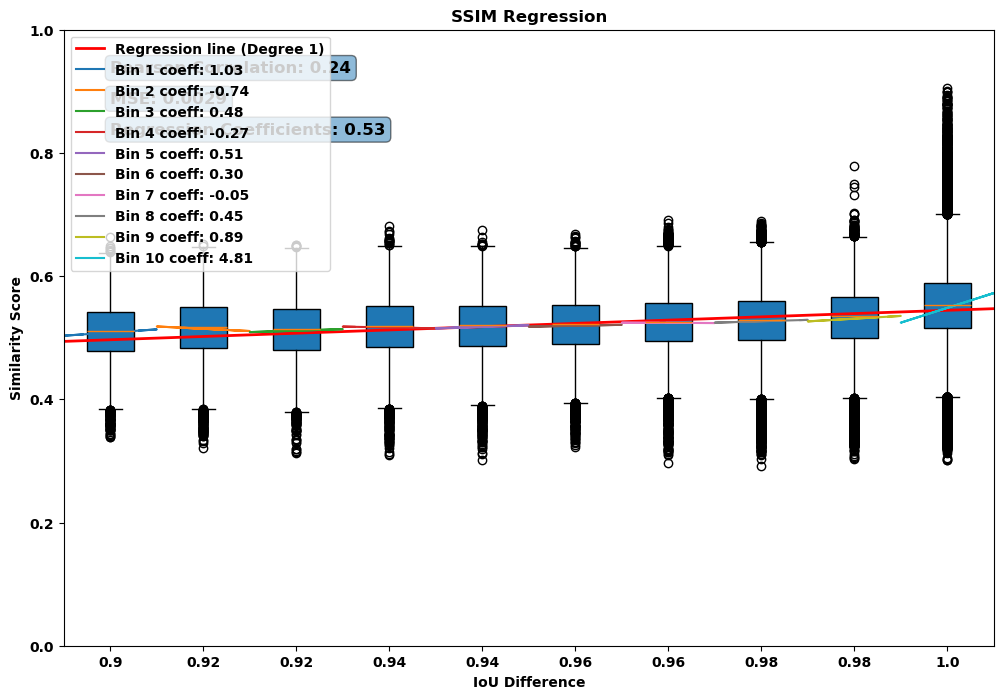

SSIM Last Bin Statistics: get_statistics.<locals>.Statistics(pearson=0.25239046688581385, spearman=0.29156898805035814, std=0.09222731, mean=0.548516, median=0.55291736, n_points=319712)
Combined Metric Last Bin Statistics: get_statistics.<locals>.Statistics(pearson=0.2562131965088256, spearman=0.3006638615200306, std=0.056063783945240316, mean=0.5307185160604265, median=0.5327774845299833, n_points=319712)

                    Statistics of bin 1:
                      Pearson Correlation: -0.04
                      Spearman Correlation: -0.05
                      Standard Deviation: 0.05
                      Mean: 0.50
                      Median: 0.51
                      Number of Data Points: 2353
                      Regression Coefficients: -0.39
                      MSE: 0.0025
                    

                    Statistics of bin 2:
                      Pearson Correlation: -0.01
                      Spearman Correlation: 0.00
                      Standard Devi

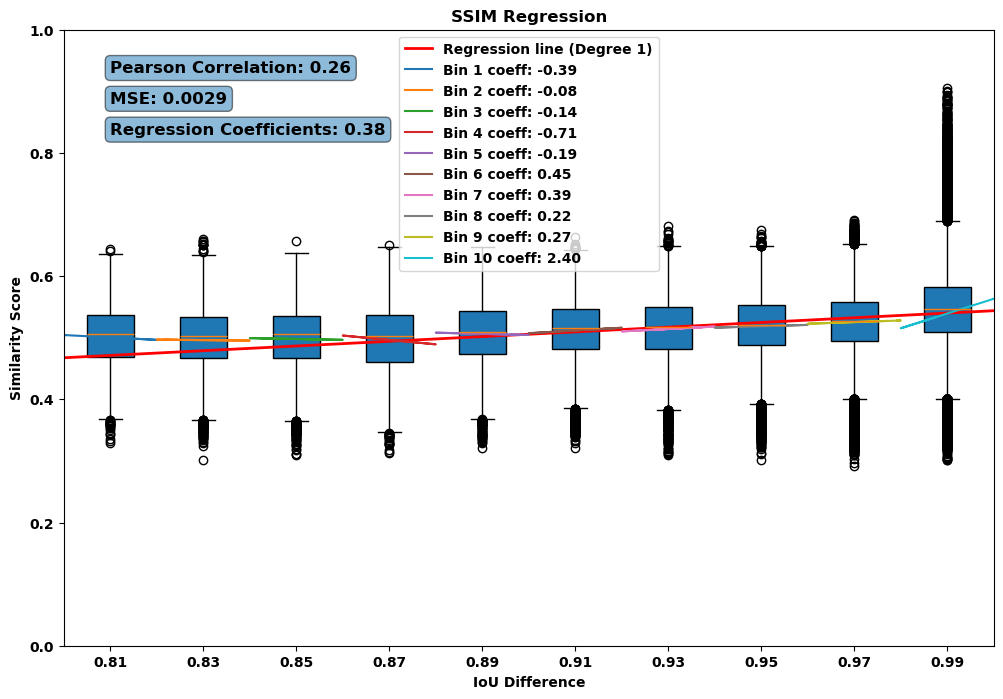

SSIM Last Bin Statistics: get_statistics.<locals>.Statistics(pearson=0.25987514452233534, spearman=0.3056038003512413, std=0.092724234, mean=0.54677045, median=0.55125487, n_points=328555)
Combined Metric Last Bin Statistics: get_statistics.<locals>.Statistics(pearson=0.25893662795186617, spearman=0.31309876724402774, std=0.05630298212008727, mean=0.529709128933909, median=0.5317757089631558, n_points=328555)

                    Statistics of bin 1:
                      Pearson Correlation: 0.05
                      Spearman Correlation: 0.08
                      Standard Deviation: 0.05
                      Mean: 0.48
                      Median: 0.49
                      Number of Data Points: 2220
                      Regression Coefficients: 0.34
                      MSE: 0.0029
                    

                    Statistics of bin 2:
                      Pearson Correlation: 0.02
                      Spearman Correlation: 0.00
                      Standard Deviat

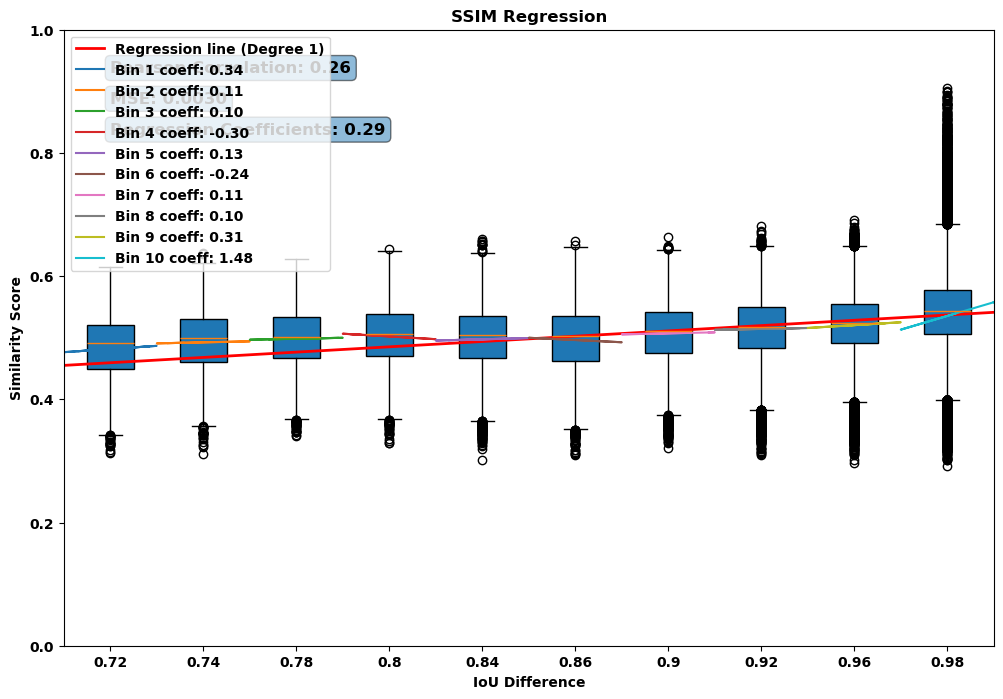

In [148]:
for i in range(2, 5):
    bin_edges = np.linspace(0, 1, 11)
    last_bin_mask = conf_similarity > bin_edges[-i]  # Assuming `bin_edges` from binning logic
    x_last_bin = conf_similarity[last_bin_mask]
    y_last_bin_ssim = ssim_matrix[last_bin_mask]
    y_last_bin_combined = combined_score[last_bin_mask]

    # Perform regression analysis for SSIM
    reg_result_ssim = fit_regression_line(x_last_bin, y_last_bin_ssim, poly_degree=1)
    stats_ssim = get_statistics(x_last_bin, y_last_bin_ssim)

    # Perform regression analysis for Combined Metric
    reg_result_combined = fit_regression_line(x_last_bin, y_last_bin_combined, poly_degree=1)
    stats_combined = get_statistics(x_last_bin, y_last_bin_combined)

    # Print results
    print(f"SSIM Last Bin Statistics: {stats_ssim}")
    print(f"Combined Metric Last Bin Statistics: {stats_combined}")

    # Plot the regression
    plot_boxplot_with_regression(x=x_last_bin, y=y_last_bin_combined, poly_degree=1, title="SSIM Regression", x_lim=(1-0.1*(i-1), 1), y_lim=(0, 1),
                                 num_bins=10, plot_bin_regression=True, verbose=True)

